In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from dateutil.parser import parse
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt

In [2]:
###TODO: expand to full data, figure out how to visualize the difference in compounds or just train multiple neural networks on each compound, fix the size error idk why thats happening

In [3]:
filenames = ["LapWeather_Australian Grand Prix.csv","LapWeather_Austrian Grand Prix.csv","LapWeather_Azerbaijan Grand Prix.csv","LapWeather_Bahrain Grand Prix.csv","LapWeather_Belgian Grand Prix.csv","LapWeather_Brazilian Grand Prix.csv","LapWeather_British Grand Prix.csv","LapWeather_Canadian Grand Prix.csv", "LapWeather_Chinese Grand Prix.csv","LapWeather_French Grand Prix.csv","LapWeather_German Grand Prix.csv","LapWeather_Hungarian Grand Prix.csv","LapWeather_Italian Grand Prix.csv","LapWeather_Japanese Grand Prix.csv","LapWeather_Mexican Grand Prix.csv","LapWeather_Monaco Grand Prix.csv","LapWeather_Russian Grand Prix.csv","LapWeather_Singapore Grand Prix.csv","LapWeather_Spanish Grand Prix.csv","LapWeather_United States Grand Prix.csv"]
combined_csv = pd.concat([pd.read_csv(f) for f in filenames ])
print(combined_csv)
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

     Unnamed: 0                    Time  DriverNumber                 LapTime  \
0             0  0 days 00:08:44.363000             5                     NaN   
1             1  0 days 00:10:14.925000             5  0 days 00:01:30.562000   
2             2  0 days 00:11:45.102000             5  0 days 00:01:30.177000   
3             3  0 days 00:13:14.712000             5  0 days 00:01:29.610000   
4             4  0 days 00:14:44.252000             5  0 days 00:01:29.540000   
..          ...                     ...           ...                     ...   
926         926  0 days 02:02:52.173000            20  0 days 00:01:40.578000   
927         927  0 days 02:04:32.739000            20  0 days 00:01:40.566000   
928         928  0 days 02:06:13.291000            20  0 days 00:01:40.552000   
929         929  0 days 02:07:54.121000            20  0 days 00:01:40.830000   
930         930  0 days 02:09:37.534000            20  0 days 00:01:43.413000   

     LapNumber             

In [4]:
df = pd.read_csv('combined_csv.csv')
df = df[df["IsAccurate"]==True]
print(len(df))
df = df[df["TrackStatus"]==1]
print(df)
df = df.drop(['Time','DriverNumber','WindDirection','LapStartDate', 'Unnamed: 0', 'PitOutTime', 'PitInTime', 'Sector1Time','Sector2Time','Sector3Time','Sector1SessionTime','Sector2SessionTime','Sector3SessionTime','SpeedI1','SpeedI2','SpeedST','IsPersonalBest','FreshTyre','SpeedFL','LapStartTime','Driver','TrackStatus','IsAccurate'], axis=1)
df = df.dropna()
dfOutput = df['LapTime']
train_targets = dfOutput.to_numpy()

for i in range(len(train_targets)):
    train_targets[i] = train_targets[i].replace('0 days ', '')
# print(train_targets)
actual_train_targets = []
for time in train_targets:
    td = parse(time) - parse('00:00:00')
    seconds = td.total_seconds()
    actual_train_targets.append(seconds)
# print(actual_train_targets)
dfLapTime = pd.DataFrame(actual_train_targets)

df['LapTime'] = dfLapTime
df = df.dropna()
cols = ['LapTime']
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3-Q1
df = df[(~(df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
dfInput = df.drop(['LapTime'], axis=1)
dfInput = dfInput.replace({'SUPERHARD':1, 'HARD':2, 'MEDIUM':3, 'SOFT':4,'SUPERSOFT': 5, 'ULTRASOFT': 6,'HYPERSOFT':7,"INTERMEDIATE":0,"WET":-1})
dfInput = dfInput.replace({'Ferrari':1,'Mercedes':2,'Red Bull Racing':3, 'McLaren':4, 'Renault':5, 'Force India':6, 'Sauber':7, 'Williams':8, 'Toro Rosso':9, 'Haas F1 Team':10, 'Racing Point':6})
train_inputs = dfInput.to_numpy()
inputs_array = train_inputs.astype('float64')
dfOutput = df['LapTime']
targets_array = dfOutput.to_numpy()
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)

new_shape = (len(targets_array), 1)
targets = targets.view(new_shape)
print(targets.shape)

print(inputs_array)
print(targets_array)


18288
       Unnamed: 0                    Time  DriverNumber  \
1               1  0 days 00:10:14.925000             5   
2               2  0 days 00:11:45.102000             5   
3               3  0 days 00:13:14.712000             5   
4               4  0 days 00:14:44.252000             5   
7               7  0 days 00:19:14.407000             5   
...           ...                     ...           ...   
21354         926  0 days 02:02:52.173000            20   
21355         927  0 days 02:04:32.739000            20   
21356         928  0 days 02:06:13.291000            20   
21357         929  0 days 02:07:54.121000            20   
21358         930  0 days 02:09:37.534000            20   

                      LapTime  LapNumber PitOutTime PitInTime  \
1      0 days 00:01:30.562000          2        NaN       NaN   
2      0 days 00:01:30.177000          3        NaN       NaN   
3      0 days 00:01:29.610000          4        NaN       NaN   
4      0 days 00:01:29.54

In [5]:
dataset = TensorDataset(inputs, targets)

In [6]:
val_percent = 0.2
num_rows = len(dfInput.index)
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [7]:
batch_size = 11
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_ds, batch_size, num_workers = 0)

In [8]:
input_size = len(inputs[0])
output_size = 1

In [9]:
class MultiLinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(12, 144),
            nn.ReLU(),
            nn.Linear(144,72),
            nn.ReLU(),
            nn.Linear(72,36),
            nn.ReLU(),
            nn.Linear(36,1),
            
        )
        
    def forward(self, xb):
        out = self.layers(xb)                       
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        mse_loss = nn.MSELoss()
        # cross_entropy_loss = nn.CrossEntropyLoss()
        # loss = cross_entropy_loss(out, targets)
        loss = mse_loss(out, targets)  
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        mse_loss = nn.MSELoss()
        loss = mse_loss(out, targets)    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [10]:
model = MultiLinearRegressionModel()

In [11]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1508, -0.1456,  0.1148,  ...,  0.0846, -0.2793, -0.2549],
         [ 0.0211,  0.0762, -0.2578,  ...,  0.0212, -0.1532,  0.2464],
         [ 0.2351, -0.0186,  0.1612,  ..., -0.2742,  0.0175,  0.2810],
         ...,
         [ 0.1602,  0.1947, -0.0283,  ..., -0.0645, -0.0286, -0.0927],
         [ 0.2861, -0.1225, -0.2205,  ..., -0.2446,  0.1109, -0.2380],
         [-0.2666,  0.1764, -0.1690,  ..., -0.0604,  0.2199, -0.2397]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0898, -0.2291,  0.1462, -0.2180, -0.2260,  0.2333,  0.1891,  0.1419,
         -0.1349,  0.2156,  0.1041,  0.2749, -0.0174,  0.1338, -0.2634, -0.2245,
         -0.2745,  0.2089, -0.1986, -0.1977, -0.0976, -0.1014, -0.1485, -0.1198,
          0.1416, -0.2115,  0.2703,  0.0978, -0.0322,  0.2251,  0.0091,  0.0632,
          0.0650,  0.1624, -0.0281, -0.2065,  0.0222,  0.0500, -0.1658, -0.2132,
          0.0978,  0.2102,  0.1313,  0.2774,  0.1605, -0.0610,  0.2672, -0.0576

In [12]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [13]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 7815.06787109375}


In [14]:
epochs = 10000
lr = 1e-6
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 219.0526
Epoch [40], val_loss: 194.7022
Epoch [60], val_loss: 170.2381
Epoch [80], val_loss: 198.3002
Epoch [100], val_loss: 154.9489
Epoch [120], val_loss: 144.5446
Epoch [140], val_loss: 123.9742
Epoch [160], val_loss: 109.6525
Epoch [180], val_loss: 110.1143
Epoch [200], val_loss: 101.7630
Epoch [220], val_loss: 98.0861
Epoch [240], val_loss: 104.2300
Epoch [260], val_loss: 98.6543
Epoch [280], val_loss: 95.0267
Epoch [300], val_loss: 103.0018
Epoch [320], val_loss: 101.8582
Epoch [340], val_loss: 92.4573
Epoch [360], val_loss: 87.6426
Epoch [380], val_loss: 88.2835
Epoch [400], val_loss: 90.1196
Epoch [420], val_loss: 90.9341
Epoch [440], val_loss: 84.3061
Epoch [460], val_loss: 91.1636
Epoch [480], val_loss: 84.2993
Epoch [500], val_loss: 94.9708
Epoch [520], val_loss: 92.2600
Epoch [540], val_loss: 83.5327
Epoch [560], val_loss: 79.3533
Epoch [580], val_loss: 84.3526
Epoch [600], val_loss: 79.1913
Epoch [620], val_loss: 83.1309
Epoch [640], val_loss: 114.492

In [15]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                
    prediction = predictions[0].detach()
    return target, prediction

In [16]:
input, target = val_ds[12]
predict_single(input, target, model)

(tensor([79.1890]), tensor([80.1760]))

In [17]:
input, target = val_ds[50]
predict_single(input, target, model)

(tensor([83.6090]), tensor([88.6678]))

In [22]:
def get_accuracy(predict,actual):
        predict = predict.detach().numpy()
        actual = actual.numpy()

        count = 0

        for i in range(len(actual)):
            if predict[i] >= actual[i]*.99 and predict[i] <= actual[i]*1.01:
                count+=1
        return count/len(predict)*100


In [23]:
targets = []
predictions = []
for i in range(len(val_ds)):
    input, target = val_ds[i]
    target, prediction = predict_single(input, target, model)
    # np.append(targets,target)
    targets.append(target)
    predictions.append(prediction)
    # np.append(predictions,prediction)

# print(len(predictions))
# print(targets[0])
accuracy = []
for j in range(len(predictions)-1):
    accuracy.append(get_accuracy(predictions[j],targets[j]))

In [24]:
print(np.sum(accuracy)/len(accuracy))

22.570076447033127


C:\Users\peter\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\ma\core.py:2826: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\peter\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\ma\core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

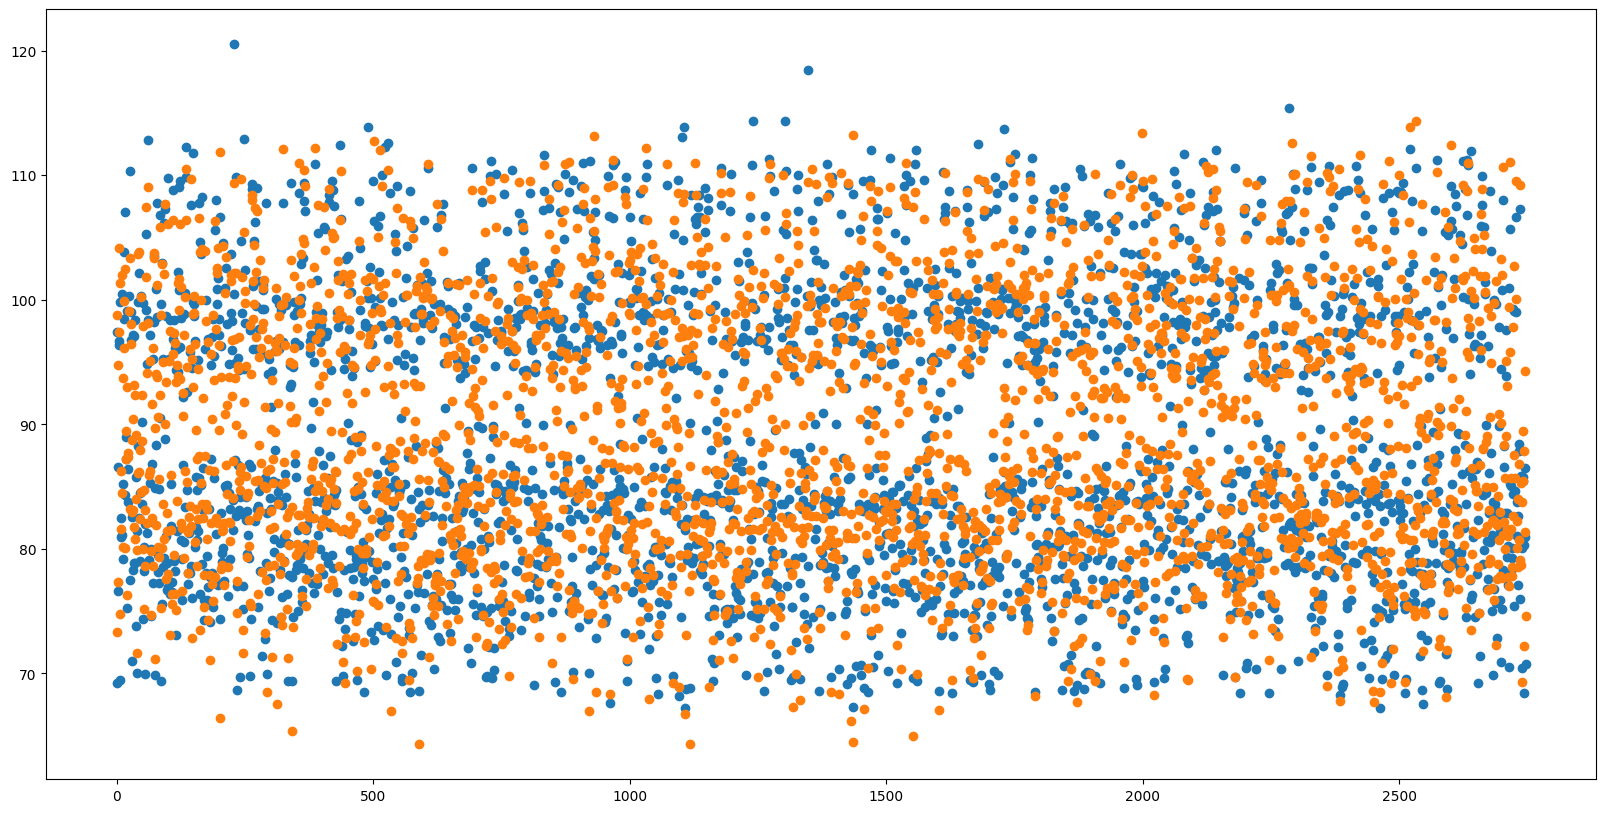

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(range(len(predictions)),targets)
ax.scatter(range(len(predictions)), predictions)
